In [1]:
import datasets
import pandas as pd
import transformers

import shap

# load the emotion dataset
dataset = datasets.load_dataset("emotion", split="train")
data = pd.DataFrame({"text": dataset["text"], "emotion": dataset["label"]})

/home/statyoung/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 272419.32 examples/s]


In [2]:
tokenizer = transformers.AutoTokenizer.from_pretrained("nateraw/bert-base-uncased-emotion", use_fast=True)
model = transformers.AutoModelForSequenceClassification.from_pretrained("nateraw/bert-base-uncased-emotion").cuda()

# build a pipeline object to do predictions
pred = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0,
    return_all_scores=True,
)

2024-12-30 10:25:12.699872: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-30 10:25:12.714598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735554312.732018  218600 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735554312.737302  218600 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-30 10:25:12.755002: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [63]:
data["text"][14]

'i have immense sympathy with the general point but as a possible proto writer trying to find time to write in the corners of life and with no sign of an agent let alone a publishing contract this feels a little precious'

In [13]:
explainer = shap.Explainer(pred)

In [25]:
shap_values = explainer(data["text"][:1])

In [29]:
shap.plots.text(shap_values)

Probability of 'Fear' class: 0.9891


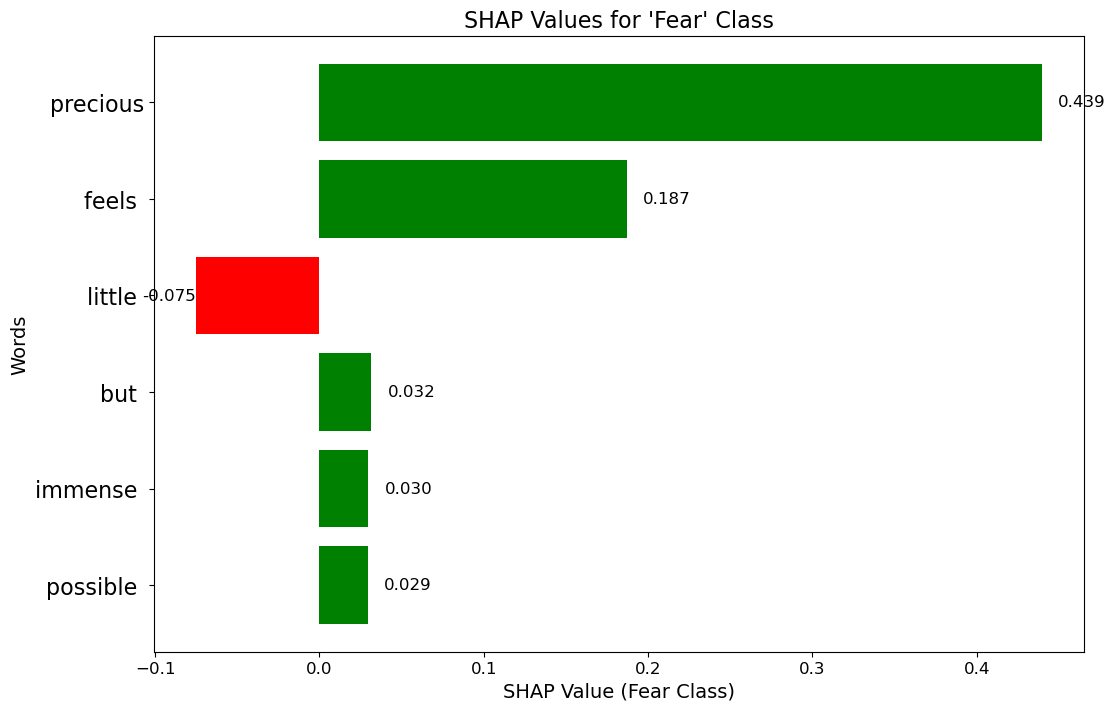

In [ ]:
import datasets
import pandas as pd
import transformers
import shap
import matplotlib.pyplot as plt

# 1. Load dataset
dataset = datasets.load_dataset("emotion", split="train")
data = pd.DataFrame({"text": dataset["text"], "emotion": dataset["label"]})

# 2. Load model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("nateraw/bert-base-uncased-emotion", use_fast=True)
model = transformers.AutoModelForSequenceClassification.from_pretrained("nateraw/bert-base-uncased-emotion").cuda()

# 3. Create prediction pipeline
pred = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0,
    return_all_scores=True,
)

# 4. Initialize SHAP explainer
explainer = shap.Explainer(pred)

# 5. Compute SHAP values for a specific sample
shap_values = explainer(data["text"][14:15])  # Using the 14th text sample

# 6. Extract SHAP values for the "Fear" class
class_names = ["anger", "fear", "joy", "love", "sadness", "surprise"]
fear_index = class_names.index("fear")

# Retrieve SHAP values for the "Fear" class of the selected sample
shap_values_for_text = shap_values[0]
shap_values_fear = shap_values_for_text.values[:, fear_index]
tokens = shap_values_for_text.data  # Extract tokenized words

# Compute predicted probability for the "Fear" class
fear_probability = pred([data["text"].iloc[14]])[0][fear_index]["score"]  # Input should be a list
print(f"Probability of 'Fear' class: {fear_probability:.4f}")

# 7. Sort words by their SHAP values
shap_dict = dict(zip(tokens, shap_values_fear))
sorted_shap = sorted(shap_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Select top 6 words with the highest SHAP values
top_words, top_values = zip(*sorted_shap[:6])

# 8. Visualize SHAP values using a bar chart
plt.figure(figsize=(12, 8))
colors = ['green' if val > 0 else 'red' for val in top_values]  # Positive: green, Negative: red
bars = plt.barh(top_words, top_values, color=colors)

# Display SHAP values on bars
for bar, value in zip(bars, top_values):
    plt.text(
        bar.get_width() - 0 if value < 0 else bar.get_width() + 0.01,  # Adjust text position based on sign
        bar.get_y() + bar.get_height() / 2,  # Center text within the bar
        f"{value:.3f}",  # Display SHAP value with three decimal places
        va='center',
        ha='left' if value > 0 else 'right',  # Align text based on sign
        fontsize=12
    )

plt.xlabel("SHAP Value (Fear Class)", fontsize=14)
plt.ylabel("Words", fontsize=14)
plt.title("SHAP Values for 'Fear' Class", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.gca().invert_yaxis()  # Most important words appear at the top
plt.show()
